[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/XGBoostLSS/blob/master/examples/simulation_example_StudentT.ipynb)

# Imports

In [13]:
from xgboostlss.model import *
from xgboostlss.distributions.StudentT import *
from xgboostlss.datasets.data_loader import load_simulated_studentT_data

import multiprocessing
import plotnine
from plotnine import *
plotnine.options.figure_size = (20, 10)

# Data

In [2]:
train, test = load_simulated_studentT_data()
n_cpu = multiprocessing.cpu_count()

X_train, y_train = train.filter(regex="x"), train["y"].values
X_test, y_test = test.filter(regex="x"), test["y"].values

dtrain = xgb.DMatrix(X_train, label=y_train, nthread=n_cpu)
dtest = xgb.DMatrix(X_test, nthread=n_cpu)

# Distribution Selection

In [3]:
# Specifies Student-T distribution with exp response function and option to stabilize Gradient/Hessian.
xgblss = XGBoostLSS(
    StudentT(stabilization="None",        # Options are "None", "MAD", "L2".
             response_fn="softplus",      # Function to transform the df and scale parameters, e.g., "exp" or "softplus".
             loss_fn="nll"                # Loss function. Options are "nll" (negative log-likelihood) or "crps"(continuous ranked probability score).
            )
)

# Hyper-Parameter Optimization

In [4]:
# Any XGBoost hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    # Float/Int sample_type
        # {"param_name": ["sample_type", low, high, log]}
            # sample_type: str, Type of sampling, e.g., "float" or "int"
            # low: int, Lower endpoint of the range of suggested values
            # high: int, Upper endpoint of the range of suggested values
            # log: bool, Flag to sample the value from the log domain or not
        # Example: {"eta": "float", low=1e-5, high=1, log=True]}

    # Categorical sample_type
        # {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            # sample_type: str, Type of sampling, either "categorical"
            # choice1, choice2, choice3, ...: str, Possible choices for the parameter
        # Example: {"booster": ["categorical", ["gbtree", "dart"]]}

    # For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        # {"param_name": ["none", [value]]},
            # param_name: str, Name of the parameter
            # value: int, Value of the parameter
        # Example: {"gpu_id": ["none", [0]]}

# Depending on which parameters are optimized, it might happen that some of them are not used, e.g., when {"booster":  ["categorical", ["gbtree", "gblinear"]]} and {"max_depth": ["int", 1, 10, False]} are
# specified, max_depth is not used when gblinear is sampled, since it has no such argument.

param_dict = {
    "eta":              ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":        ["int",   {"low": 1,      "high": 10,    "log": False}],
    "gamma":            ["float", {"low": 1e-8,   "high": 40,    "log": True}],
    "subsample":        ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "colsample_bytree": ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "min_child_weight": ["float", {"low": 1e-8,   "high": 500,   "log": True}],
    "booster":          ["categorical", ["gbtree"]],
    # "tree_method":    ["categorical", ["auto", "approx", "hist", "gpu_hist"]],
    # "gpu_id":         ["none", [0]]
}

np.random.seed(123)
opt_param = xgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=200,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=10,             # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=None,              # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

[I 2023-05-18 08:59:14,118] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization
C:\Users\maerzale\.virtualenvs\XGBoostLSS-vIPRRz-M\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


   0%|          | 00:00/10:00

[I 2023-05-18 08:59:18,738] Trial 0 finished with value: 3215.2696287999997 and parameters: {'eta': 0.07628649519101742, 'max_depth': 4, 'gamma': 1.6581161397030458e-05, 'subsample': 0.8278783655111042, 'colsample_bytree': 0.8427756915542317, 'min_child_weight': 8.265343268168529, 'booster': 'gbtree'}. Best is trial 0 with value: 3215.2696287999997.
[I 2023-05-18 08:59:42,717] Trial 1 finished with value: 3238.3711426 and parameters: {'eta': 0.006931017569567469, 'max_depth': 2, 'gamma': 0.005779174451185646, 'subsample': 0.30100555158818953, 'colsample_bytree': 0.4792575863632664, 'min_child_weight': 0.0017989109644240765, 'booster': 'gbtree'}. Best is trial 0 with value: 3215.2696287999997.
[I 2023-05-18 09:00:10,969] Trial 2 finished with value: 3381.5832034 and parameters: {'eta': 7.31857720721673e-05, 'max_depth': 2, 'gamma': 22.53835466129682, 'subsample': 0.6114449478555843, 'colsample_bytree': 0.8368430798890476, 'min_child_weight': 2.0580710230593286e-06, 'booster': 'gbtree'}.

# Model Training

In [5]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
xgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

# Prediction

In [6]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
quant_sel = [0.05, 0.95] # Quantiles to calculate from predicted distribution

# Sample from predicted distribution
pred_samples = xgblss.predict(dtest,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = xgblss.predict(dtest,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = xgblss.predict(dtest,
                             pred_type="parameters")

In [7]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,1.726764,6.100464,1.520407,1.584609,2.574122,1.030770,-3.105422,0.155674,2.187609,3.538782,...,-1.669110,1.227274,-1.486293,-0.338102,1.088643,1.271401,1.021241,3.480693,-0.589313,0.163924
1,1.015110,-0.947994,0.273334,1.575565,1.095958,3.794791,5.209265,0.814379,4.467658,0.962750,...,3.859976,1.769070,-1.059898,-0.883022,-1.285496,0.531791,2.124393,-3.088178,8.138264,1.780903
2,1.565645,2.358168,2.419116,2.848689,2.124624,4.470554,4.333276,0.234125,2.389472,2.555428,...,3.048846,3.872010,1.616533,2.325969,1.212024,0.680830,3.488111,3.158257,0.706685,3.744848
3,-0.744928,0.394222,2.749652,0.417942,0.057327,2.967678,1.802242,-2.264524,0.477104,-0.344853,...,6.844858,2.192294,3.395278,-1.686308,0.199534,1.265213,2.439299,-1.110343,-1.510190,-0.193336
4,3.263926,-4.657651,0.747744,2.274629,-0.617732,0.527329,2.967484,0.256437,2.282986,1.387291,...,1.271424,5.331562,4.669413,5.414660,3.592356,2.845491,1.079442,1.233249,0.419483,-0.305479


In [8]:
pred_quantiles.head()

,quant_0.05,quant_0.95
0,-1.437250,3.704222
1,-1.799743,4.732620
2,-0.820749,5.108396
3,-2.931464,4.805905
4,-0.205423,5.877630


In [9]:
pred_params.head()

,df,loc,scale
0,12.999526,1.077385,1.356311
1,12.999526,1.355083,1.912580
2,12.999526,2.020340,1.691013
3,12.999526,0.797617,2.195763
4,12.999526,2.746580,1.769171


# SHAP Interpretability

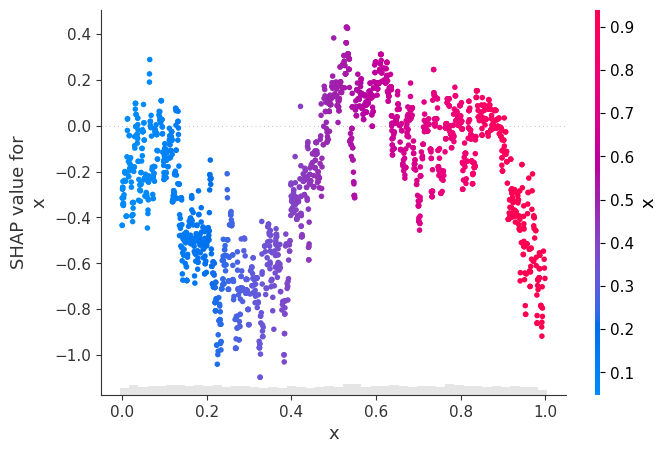

In [10]:
# Partial Dependence Plot of how x acts on variance
xgblss.plot(X_test,
            parameter="scale",
            feature="x",
            plot_type="Partial_Dependence")

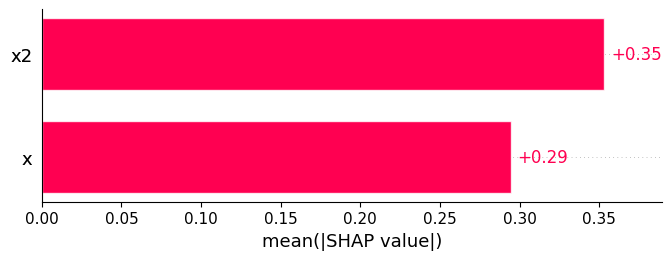

In [11]:
# Feature Importance of scale parameter
xgblss.plot(X_test,
            parameter="scale",
            plot_type="Feature_Importance")

# True vs. Predicted Distributional Parameters

In the following figure, we compare the true parameters of the Student-T with the ones predicted by XGBoostLSS. The below figure shows that the estimated parameters closely match the true ones.

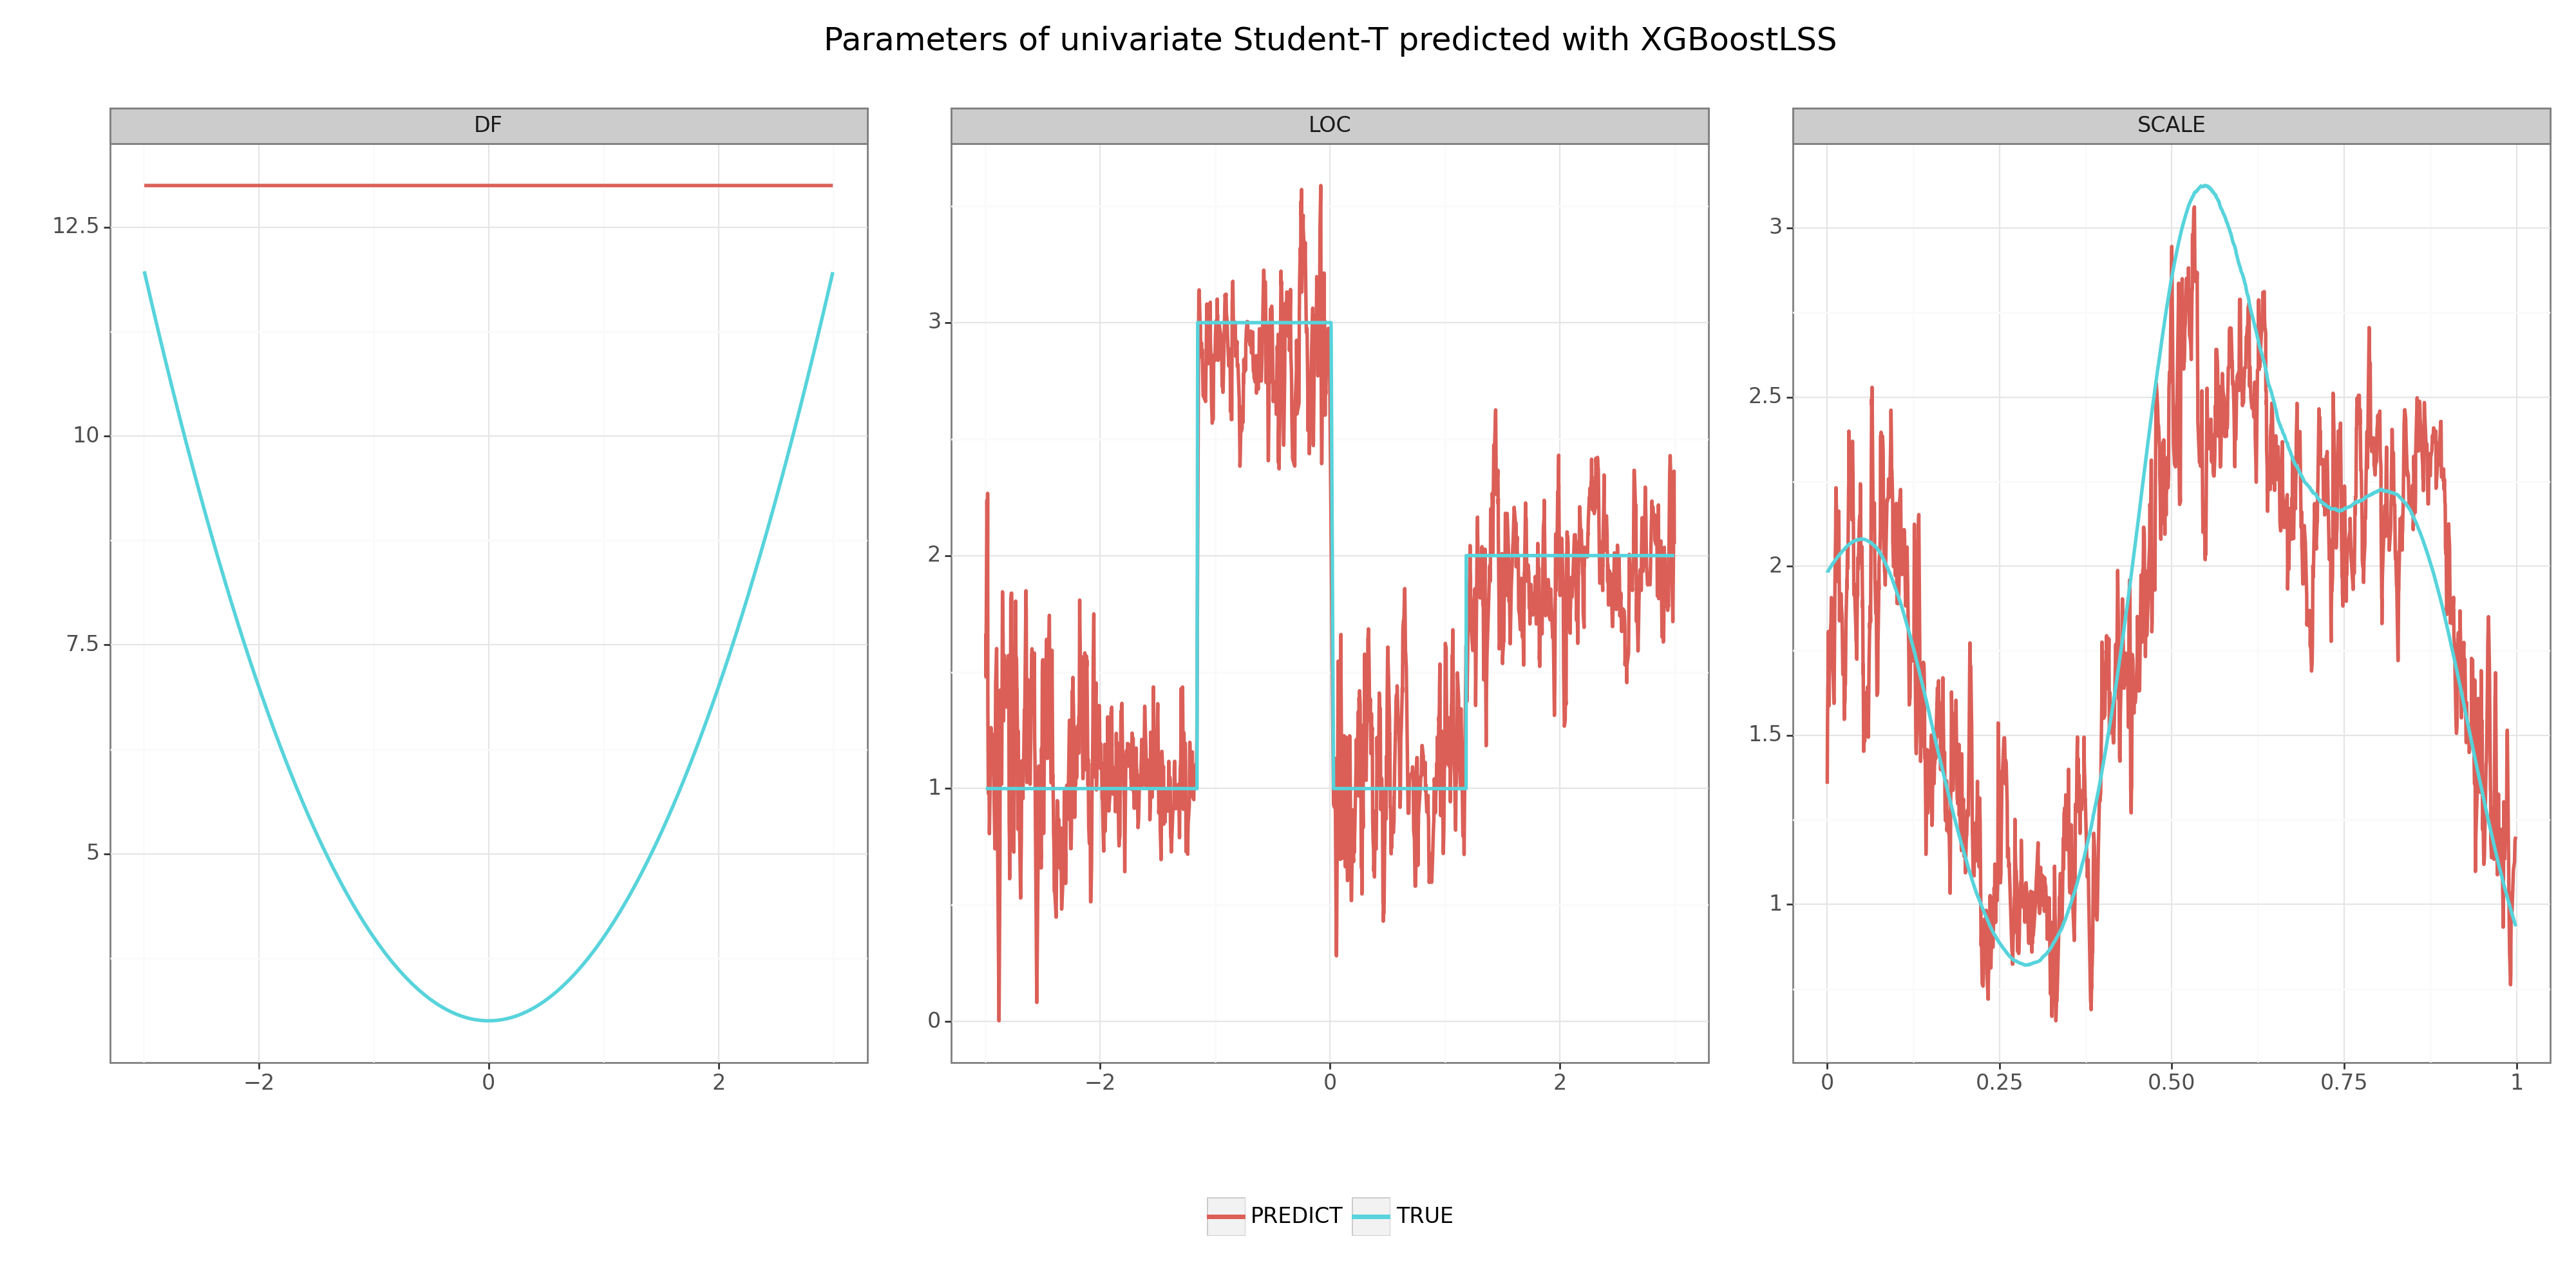

<Figure Size: (2000 x 1000)>

In [12]:
pred_params["x"] = X_test["x"].values
pred_params["x2"] = X_test["x2"].values

# Data with actual values
plot_df_actual_scale =  pd.melt(test[["x", "scale"]],
                                id_vars=["x"],
                                value_vars=["scale"])
plot_df_actual_df_loc =  pd.melt(test[["x2", "df", "loc"]],
                                 id_vars=["x2"],
                                 value_vars=["df", "loc"])

plot_df_actual_df_loc.columns = list(plot_df_actual_scale.columns)
plot_df_actual = pd.concat([plot_df_actual_scale, plot_df_actual_df_loc])
plot_df_actual["type"] = "TRUE"


# Data with predicted values
plot_df_predt_scale =  pd.melt(pred_params[["x", "scale"]],
                               id_vars=["x"],
                               value_vars=["scale"])

plot_df_predt_df_loc =  pd.melt(pred_params[["x2", "df", "loc"]],
                                id_vars=["x2"],
                                value_vars=["df", "loc"])

plot_df_predt_df_loc.columns = list(plot_df_predt_scale.columns)
plot_df_predt= pd.concat([plot_df_predt_scale, plot_df_predt_df_loc])
plot_df_predt["type"] = "PREDICT"

plot_df = pd.concat([plot_df_actual, plot_df_predt])
plot_df["variable"] = plot_df.variable.str.upper()
plot_df["type"] = pd.Categorical(plot_df["type"], categories = ["PREDICT", "TRUE"])

(ggplot(plot_df,
        aes(x="x",
            y="value",
            color="type")) +
 geom_line(size=1.1) +
 facet_wrap("variable",
            scales="free") +
 labs(title="Parameters of univariate Student-T predicted with XGBoostLSS",
      x="",
      y="") +
 theme_bw(base_size=15) +
 theme(legend_position="bottom",
       plot_title = element_text(hjust = 0.5),
       legend_title = element_blank())
)